In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
import statsmodels.api as sm
from patsy import dmatrix

In [2]:
data = pd.read_csv('data/Wage.csv', index_col=0).reset_index(drop=True)
data

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154
...,...,...,...,...,...,...,...,...,...,...,...
2995,2008,44,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,5.041393,154.685293
2996,2007,30,2. Married,1. White,2. HS Grad,2. Middle Atlantic,1. Industrial,2. >=Very Good,2. No,4.602060,99.689464
2997,2005,27,2. Married,2. Black,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.193125,66.229408
2998,2005,27,1. Never Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,4.477121,87.981033


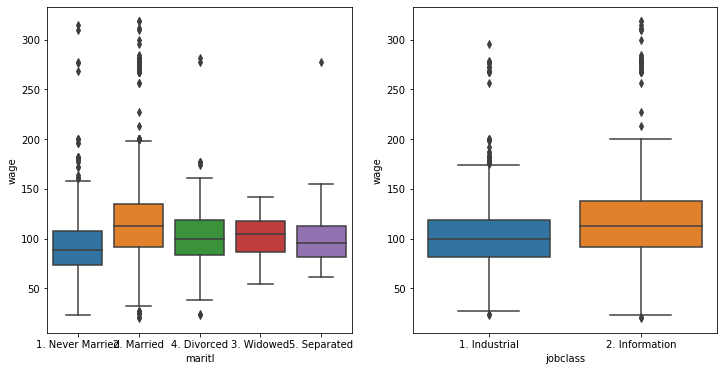

In [13]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
sb.boxplot(data=data, x='maritl', y='wage')

plt.subplot(1,2,2)
sb.boxplot(data=data, x='jobclass', y='wage')

plt.show()

In [14]:
# We can see no clear predictors maritl & jobclass related to response wage, so we should you GAM to make regression with aditional other predictors

## Generalized Additive Models

In [21]:
# Model 1
matrix_1 = dmatrix("cr(age, df=5, constraints='center') + year + education", data={'age': data['age'], 'year': data['year'], 'education': data['education']}, return_type='dataframe')

gam_1 = sm.OLS(data['wage'], matrix_1).fit()

# Model 2
matrix_2 = dmatrix("cr(age, df=5, constraints='center') + year + education + maritl", data={'age': data['age'], 'year': data['year'], 'education': data['education'], 'maritl': data['maritl']}, return_type='dataframe')
gam_2 = sm.OLS(data['wage'], matrix_2).fit()

# Model 3
matrix_3 = dmatrix("cr(age, df=5, constraints='center') + year + education + maritl + jobclass", data={'age': data['age'], 'year': data['year'], 'education': data['education'], 'maritl': data['maritl'], 'jobclass': data['jobclass']}, return_type='dataframe')
gam_3 = sm.OLS(data['wage'], matrix_3).fit()

# ANOVA test GAM models
anova = sm.stats.anova_lm(gam_1, gam_2, gam_3)
print(anova)

   df_resid           ssr  df_diff       ss_diff          F        Pr(>F)
0    2989.0  3.695015e+06      0.0           NaN        NaN           NaN
1    2985.0  3.600744e+06      4.0  94270.900005  19.608149  6.052176e-16
2    2984.0  3.586575e+06      1.0  14169.313324  11.788749  6.040181e-04


In [22]:
print(gam_3.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     90.72
Date:                Thu, 22 Oct 2020   Prob (F-statistic):          4.47e-230
Time:                        14:04:48   Log-Likelihood:                -14886.
No. Observations:                3000   AIC:                         2.980e+04
Df Residuals:                    2984   BIC:                         2.990e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [23]:
# With anova test, it show maritl and jobclass can have value when add to model
# only p-value of maritl[T.2. Married] and jobclass[T.2. Information] small enough to reject hypothesis and have value significant when forcast wage value

In [32]:
# Get year coef
maritl_coef = gam_3.params[5:9]
jobclass_coef = gam_3.params[9]

# Get columns in GAM1_matrix for year basis function
maritl_basis = matrix_3.iloc[:,5:9]
jobclass_basis = matrix_3.iloc[:,9]

# F1(year) values, F2(age), F3(education)
maritl_f4 = np.dot(maritl_basis, maritl_coef)
jobclass_f5 = np.dot(jobclass_basis, jobclass_coef)

# Get order x axis
order_maritl = np.argsort(data['maritl'].values)
order_jobclass = np.argsort(data['jobclass'].values)

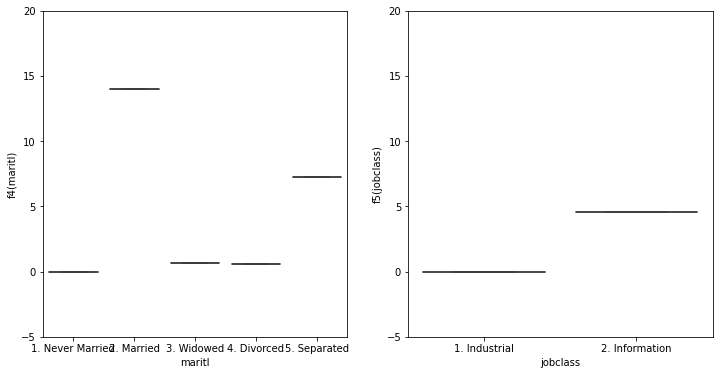

In [35]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sb.boxplot(x=data['maritl'][order_maritl], y=maritl_f4[order_maritl])
plt.ylabel('f4(maritl)')
plt.ylim([-5,20])

plt.subplot(1,2,2)
sb.boxplot(x=data['jobclass'][order_jobclass], y=jobclass_f5[order_jobclass])
plt.ylabel('f5(jobclass)')
plt.ylim([-5,20])

plt.show()